In [2]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

2025-04-03 15:58:22.785458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743717502.804233   89810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743717502.809786   89810 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 15:58:22.828124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First we load the data

In [3]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [4]:
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H64')

# Then we explore the series, with distribution, the ACF, PACF, moving avg, decomposition and descriptive statistics

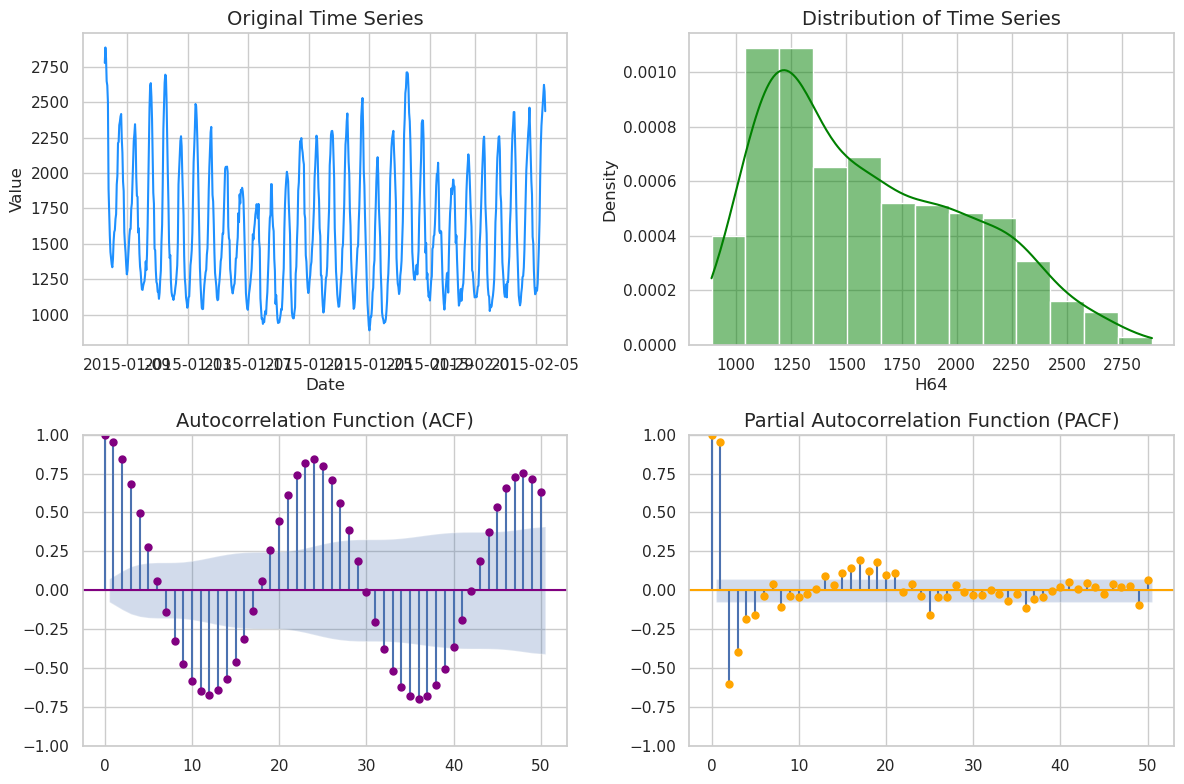

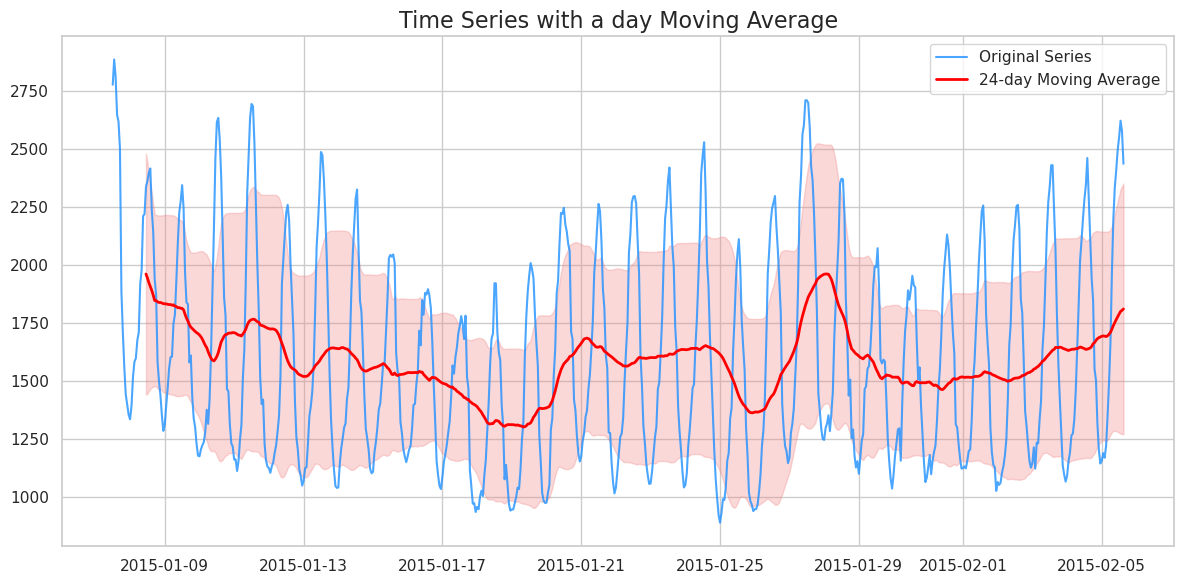

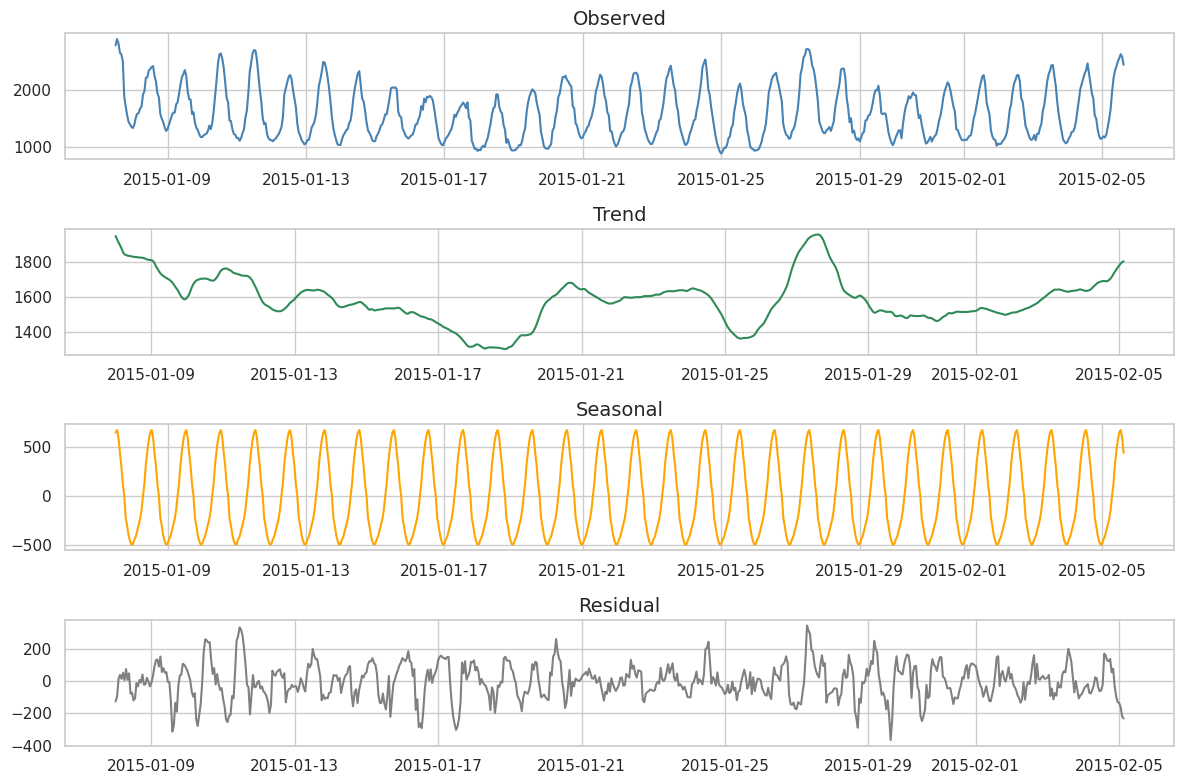

Descriptive Statistics:
count     700.000000
mean     1599.805714
std       452.485698
min       888.000000
25%      1217.750000
50%      1511.500000
75%      1938.250000
max      2886.000000
Name: H64, dtype: float64

Shapiro-Wilk Test p-value: 8.506812769768022e-16
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -2.4917559777311955
p-value: 0.11749309155374671
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [5]:
univariate_data_analysis(ts)

- **Distribution:**  
  We can see a distribution a bit **skewed**, and not normal at all, suggesting like in previous series that we have many states on the data.

- **Autocorrelation:**  
  A clear pattern emerges **every 24 hours**, reinforcing the fact that the series exhibits **daily seasonality**.  

- **Partial Autocorrelation:**  
  Significant spikes at the **first and second lags** indicate a **strong autoregressive component**. This means that **previous observations** have a **major impact** on the next ones.  

- **ADF Test:**  
  The test suggests that the series is **non-stationary**, aligning with the **seasonal patterns** previously observed.  

- **Moving Average Analysis:**  
  The daily moving average captures the underlying trend while smoothing out the daily fluctuations, showing an almost consistent horizontal trend.

- **ADF and SWT**
  Both tests shows that the serie is not stationary and not normal.

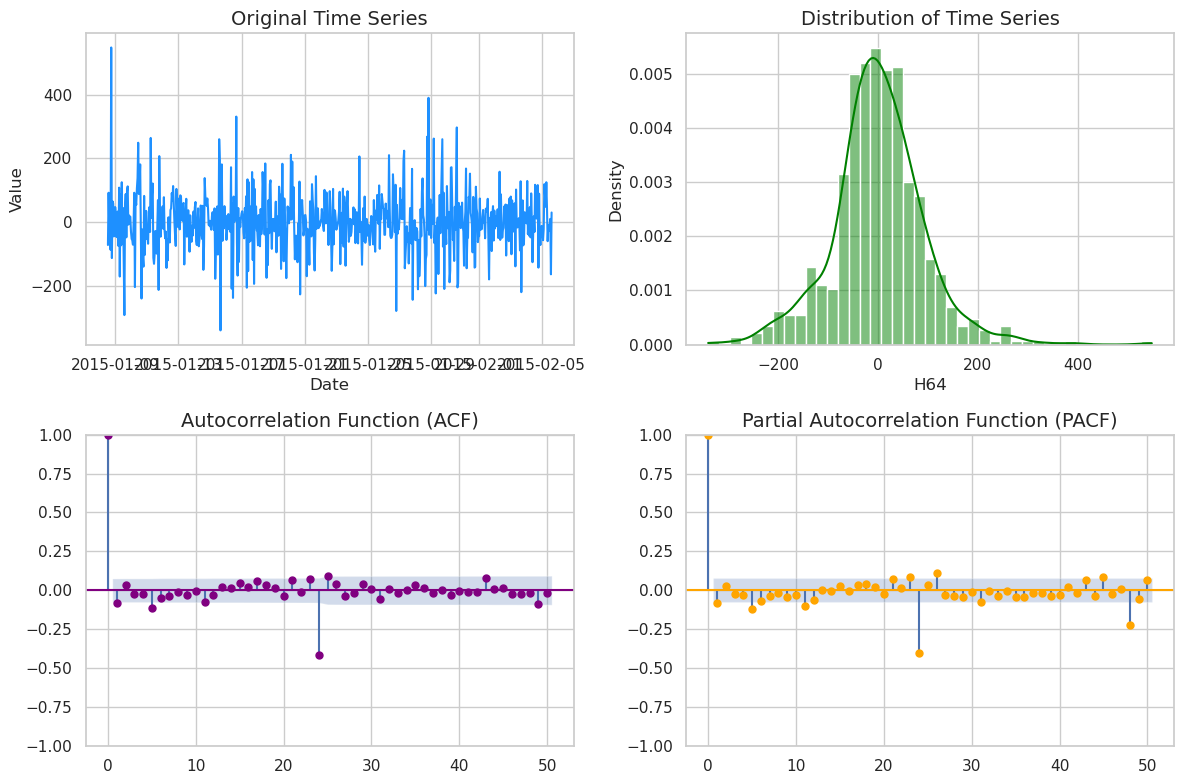

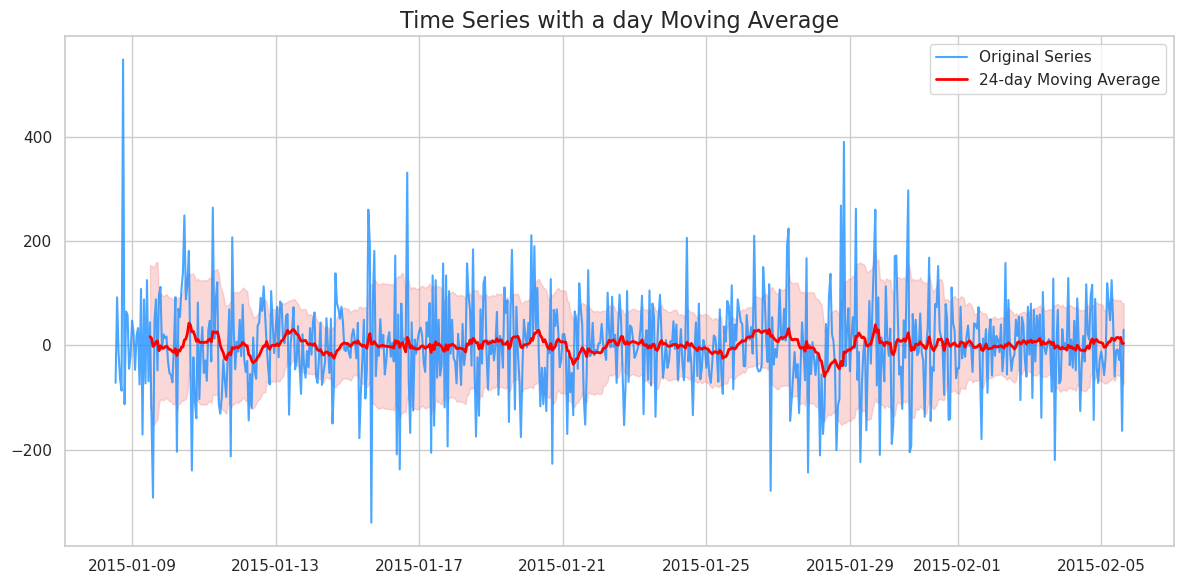

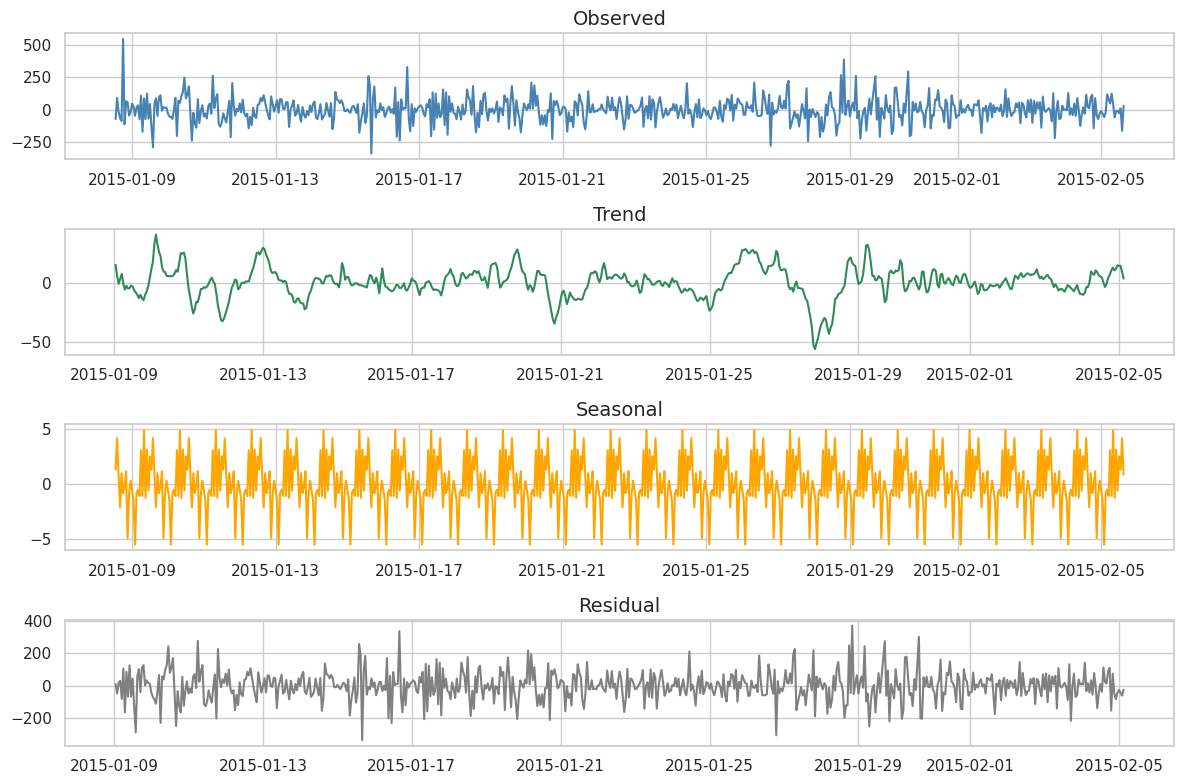

Descriptive Statistics:
count    675.000000
mean       0.828148
std       91.623035
min     -340.000000
25%      -46.500000
50%       -2.000000
75%       49.000000
max      548.000000
Name: H64, dtype: float64

Shapiro-Wilk Test p-value: 2.46830039046797e-11
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -10.342921778575127
p-value: 2.656242037914922e-18
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [7]:
univariate_data_analysis(ts.diff(24).diff().dropna())

As we can see, **differencing the series** for **SARIMAX modeling** could be a good idea.  

From the **decomposition**, we observe that:  
- The **seasonal component** is the most **dominant** but also pretty complex.  
- The **trend gets lost** after applying **simple differencing**, **24-hour differencing**, and **24-hour + simple differencing**.  
- We end up with a pretty **noisy** residual.

We'll keep on the NN approach

Train: 441, Validation: 105, Test: 106


C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MLP Model 1 MAE: 71.6220450052401
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MLP Model 2 MAE: 112.9322509765625
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023B033A9940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MLP Model 3 MAE: 67.12219387147485
3/3 ━━━━━━━━━━━━━━━

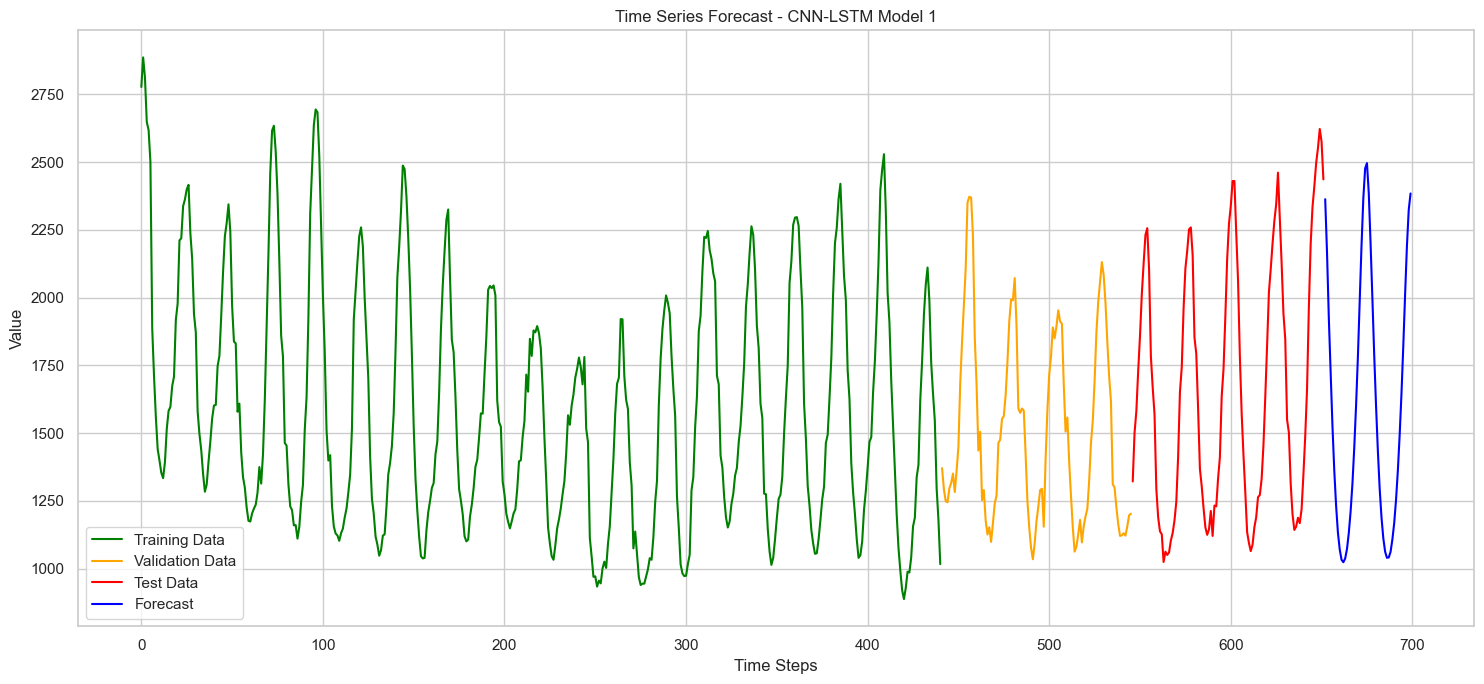

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


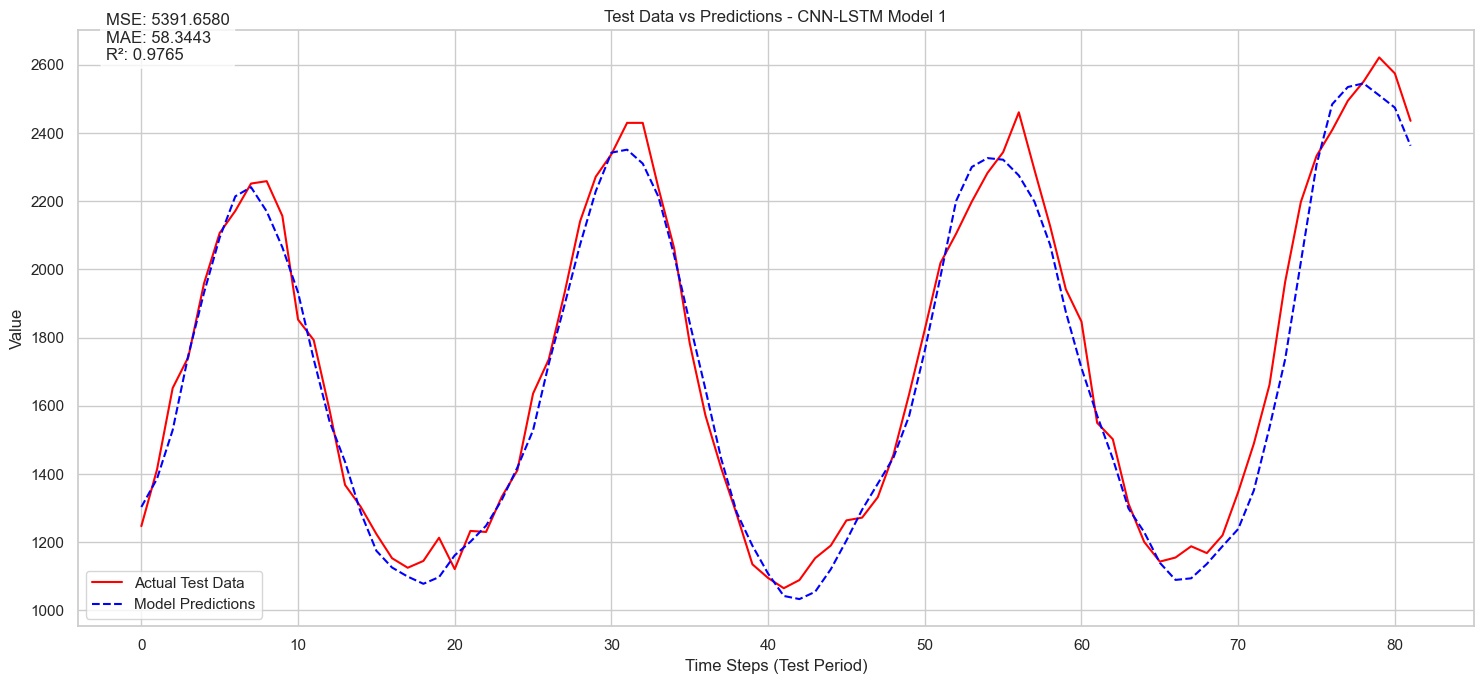


Model Performance Comparison:
      Model Type  Mean Absolute Error
CNN-LSTM Model 1            58.344305
    LSTM Model 1            59.281557
CNN-LSTM Model 3            66.531682
     MLP Model 3            67.122194
    LSTM Model 3            69.985925
     MLP Model 1            71.622045
     CNN Model 1            75.830336
    LSTM Model 2            99.712210
     MLP Model 2           112.932251
     CNN Model 2           113.641567
CNN-LSTM Model 2           184.791988
     CNN Model 3           333.640148


In [5]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

The best model was a **CNN-LSTM** with:  
- **1 Conv1D layer** with **64 filters** and **kernel size of 3**  
- **1 MaxPooling1D layer** with **pool size of 2**  
- **1 TimeDistributed Dense layer** with **25 neurons**  
- **1 LSTM layer** with **50 neurons**  
- **1 Dense output layer** with **1 neuron**  
- **Activation function:** ReLU  

## Best MLP Model Optimization Results

### Summary
- **Number of trials:** 200
- **Best trial value (MAE):** 0.004735623020678759
- **Best hyperparameters:**  
  - **Optimizer:** Adam  
  - **Learning rate:** 0.0008420183450492546  
  - **Activation:** ELU  
  - **Number of layers:** 2  
  - **Neurons per layer:**  
    - **Layer 0:** 169  
    - **Layer 1:** 126  
  - **Dropout (Layer 1):** 9.97854530457433e-05  


We achieved a **0.442 MAE**, on the test data which is a good model outperforming by far the previous model which wasnt even bad

However, the **Optuna-optimized model** like in other ts reduced the **complexity of the model** and changed some **activation functions**. This resulted in a **simpler model**.  

If our priority is **speed over performance**, we might choose to **sacrifice a little accuracy** in favor of faster computations, but in this case, the performance difference might be a little more significant if it would be of high importance.  


In [6]:
best_model['best_model'].summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 22, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 11, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,398 (200.78 KB)

 Trainable params: 17,132 (66.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,266 (133.86 KB)

# Optuna

After that, we select the model that gave the best results and optimize it with **Optuna** for:  
- **Learning rate**  
- **Activation functions**  
- **Number of layers**  
- **Number of units per layer**  
- **Optimizer**  

The function is designed to **adapt** and tune the best model architecture **regardless of its type**, as different models can perform better depending on the series. Our goal is to achieve the **optimal performance** possible.  

The experiment runs for **200 trials**, then the results are **de-scaled** and plotted against the **test set**, allowing us to compare with the previous model.  


[I 2025-03-28 18:17:39,523] A new study created in memory with name: no-name-6df83a47-98ae-41e9-ab0f-30eea9cba388
c:\Users\dosju\Downloads\Examen2NL\pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-03-28 18:17:44,940] Trial 0 finished with value: 0.0346071757376194 and parameters: {'optimizer': 'rmsprop', 'learning_

Best MLP Model Optimization Results:
  Number of trials: 100
  Best trial value (MAE): 0.02740265615284443
  Best hyperparameters:
    optimizer: adam
    learning_rate: 0.0007622390328190751
    activation: relu
    n_layers: 3
    neurons_0: 237
    neurons_1: 116
    dropout_1: 0.12074250954704185
    neurons_2: 48
    dropout_2: 0.13227983219384049
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

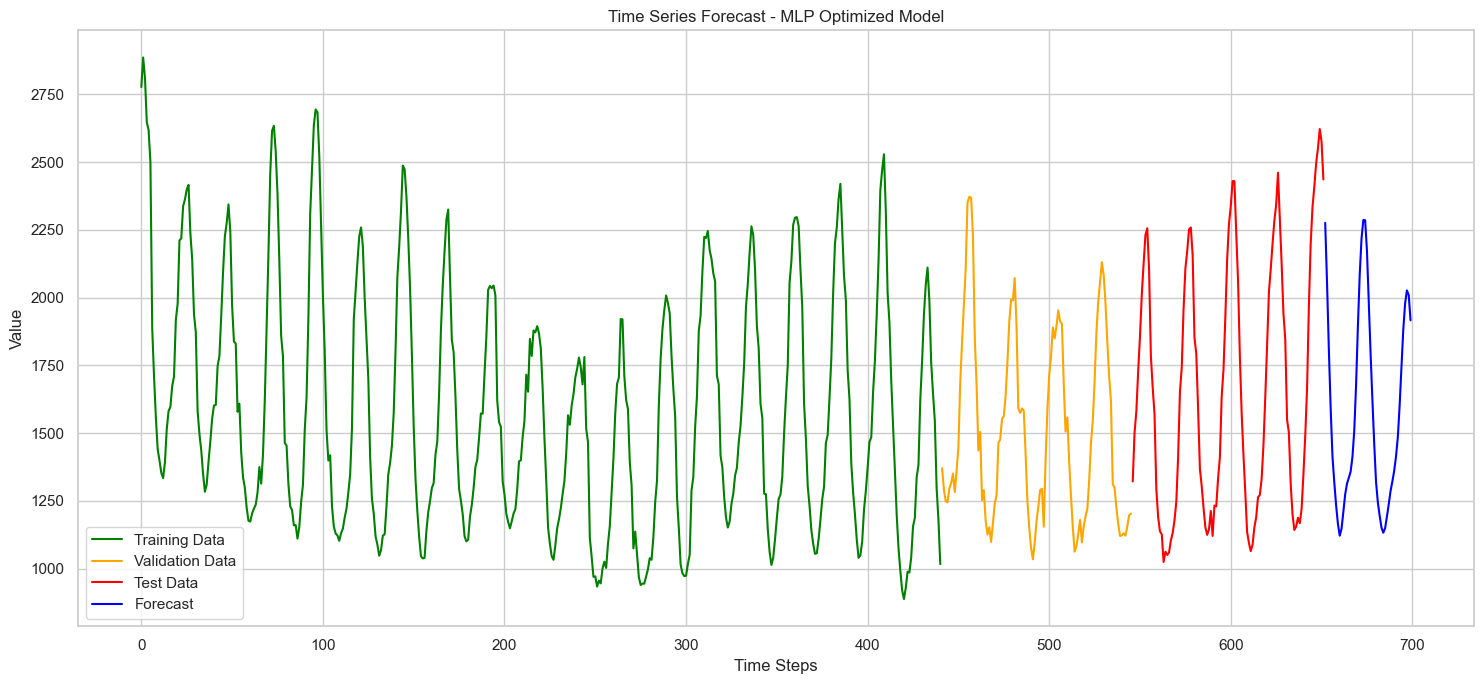


Test Data Prediction Analysis:


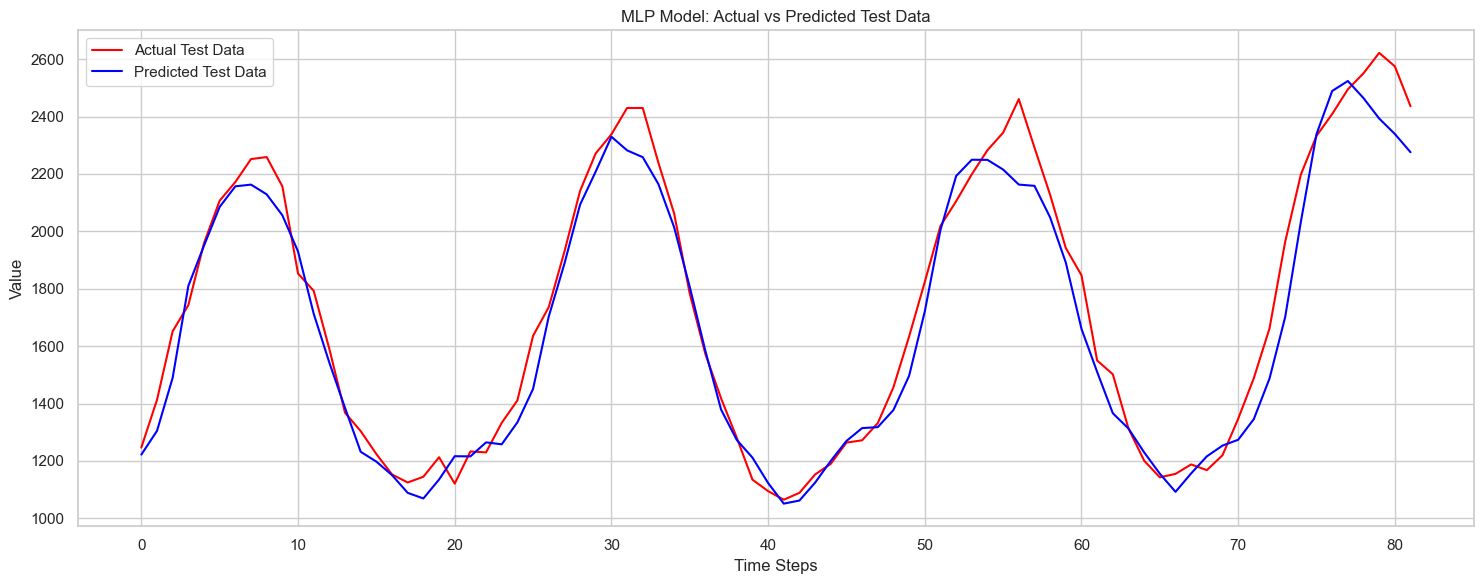


Model Performance Metrics:
Mean Absolute Error (MAE): 74.4614570431593
Mean Squared Error (MSE): 9683.77294982261


In [ ]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']

## After 100 Experiments, We Obtained the Best Architecture

### Best MLP Model Optimization Results:

- **Number of trials:** 100  
- **Best trial value (MAE):** 0.02740265615284443  
- **Best hyperparameters:**
  - **Optimizer:** adam  
  - **Learning rate:** 0.0007622390328190751  
  - **Activation:** relu  
  - **Number of layers:** 3  
  - **Neurons per layer:**
    - **Layer 0:** 237  
    - **Layer 1:** 116  
    - **Dropout (Layer 1):** 0.12074250954704185  
    - **Layer 2:** 48  
    - **Dropout (Layer 2):** 0.13227983219384049  

We achieved a **27.4 MAE**, demonstrating a well-optimized model, and outperforming for the first time our manual model that achieved a MAE of **58.34**
